### **Convolutional Neural Network**

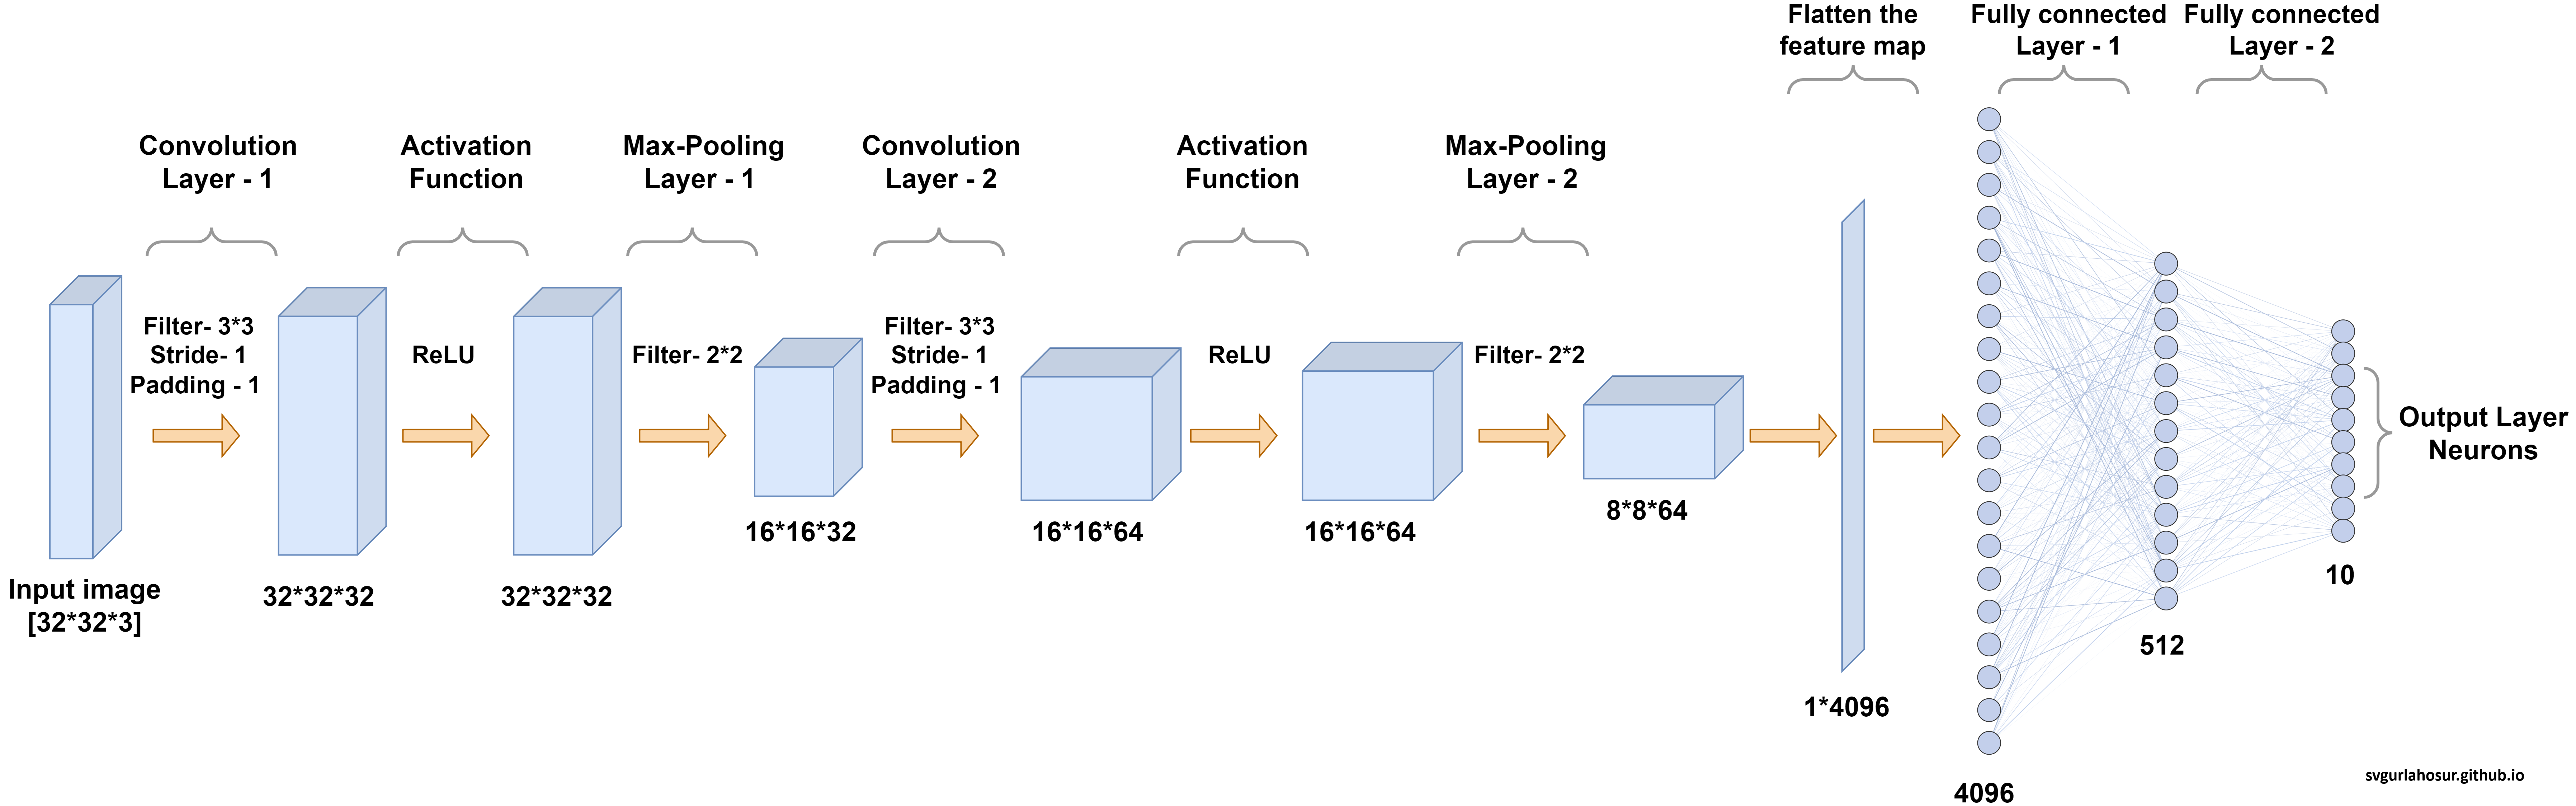

### **1. Import libraries, download dataset and apply transformations on the datasets**

In [1]:
# import the libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys

# Define transformations to convert images into multi-dimensional tensors and normalize pixel values with a mean and standard deviation of 0.5 for all the channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download CIFAR-10 dataset and apply transformations,train=True downloads the training dataset and train=False downloads the testing dataset
trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./dataset', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 43955254.66it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


### **2. Build the training and testing dataloaders**

In [2]:
# For testloader, shuffling is not needed since model does not learn from the testing dataset
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

### **3. Visualize the training images to see how images from the CIFAR10 dataset would look like**

The total number of images loaded per batch are 128, and the shape of each image is torch.Size([3, 32, 32])


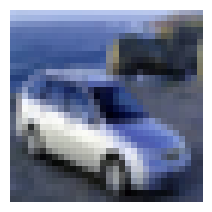

The label name of the displayed image is car


In [27]:
#Create a tuple to store names of all the 10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Iterate through the trainloader once, to get a batch of training images and labels
images, labels = next(iter(trainloader))

# images is a batch tensor with dimensions [batch_size, channels, height, width]
print(f"The total number of images loaded per batch are {images.shape[0]}, and the shape of each image is {images[0].shape}")

# Selecting the first image from the batch (index 0)
image = images[0]
# Transpose the image tensor to rearrange dimensions for visualization, [channels, height, width] to [height, width, channels]
image = image.permute(1, 2, 0)
# Reverse the normalization with mean=0.5, std=0.5
image = image * 0.5 + 0.5
# Clip values to ensure they are within valid range [0, 1] for display
image = torch.clamp(image, 0, 1)
# Convert tensor to numpy array for visualization
image = image.numpy()
plt.figure(figsize=(2.5,2.5))
# Display the image using Matplotlib
plt.imshow(image)
# Turn off axis labels
plt.axis('off')
plt.show()
print(f"The label name of the displayed image is {classes[labels[0]]}")

### **4. Define the Convolutional Neural Network**

In [28]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### **5. Define loss function, and optimization algorithm**

In [29]:
# Create an instance of the Network class
model = Network()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### **6. Train the model using training dataset, validate the model using training dataset and implement the early stop mechanism for the model training**

In [30]:
# Set the number of training epochs
epochs = 40

# Initialize an empty list to store training losses for each epoch
train_loss_list = []

# Initialize an empty list to store training accuracy for each epoch
train_accuracy_list = []

# Initialize an empty list to store per-class training accuracy for each epoch
train_per_class_accuracy_list = []

# Initialize an empty list to store top-k training accuracy for each epoch
train_top_k_accuracy_list = []

# Initialize an empty list to store testing accuracy for each epoch
test_accuracy_list = []

# Initialize an empty list to store testing loss for each epoch
test_loss_list = []

# Initialize an empty list to store per-class testing accuracy for each epoch
test_per_class_accuracy_list = []

# Initialize an empty list to store top-k testing accuracy for each epoch
test_top_k_accuracy_list = []

# Set the maximum number of allowed epochs with no improvement
max_temperature = 5

# Initlize the best testing loss to infinity
best_test_loss = float('inf')

# Set the best test accuracy and epoch to zero
best_test_accuracy_top_1 = 0.0
best_test_epoch = 0

# Iterate over the specified number of epochs
for epoch in tqdm(range(epochs)):
  # Initialize the cumulative training loss to zero, for the current epoch
  train_loss_epoch = 0.0
  # Iterate through the train loader to process batches of train images
  print("\n-------------------------------------------------------------Training-------------------------------------------------------------")
  for images, labels in trainloader:
    # Move data and model to the specified device (CPU or GPU)
    images, labels = images.to(device), labels.to(device)
    # Zero out the gradients to prevent accumulation
    optimizer.zero_grad()
    # Forward propogation - compute model predictions
    outputs = model(images)
    # Compute the loss/error between predictions and actual labels
    loss = criterion(outputs, labels)
    # Backward propogation - compute gradients and update model weights
    loss.backward()
    optimizer.step()
    # Accumulate the batch loss to the epoch's cumulative loss
    train_loss_epoch += loss.item()
  # Append the cumulative loss for the epoch to the list
  train_loss_list.append(train_loss_epoch)

  # Print Training loss per epoch
  print(f"The training loss for the epoch {epoch+1} is: {train_loss_epoch}")

  # Disable gradient computation since model is only evaluated and which further increase the speed of evaluation
  with torch.no_grad():
    # Initialize variables for overall accuracy
    train_correct = 0
    train_total = 0

    # Initialize dictionaries to track per-class accuracy
    correct_pred_train = {classname: 0 for classname in classes}
    total_pred_train = {classname: 0 for classname in classes}

    # Set the value for top-k accuracy
    top_k_value = 5
    top_k_accuracy_train = 0.0

    # Iterate over batches in the training loader
    for images, labels in trainloader:
      # Move data and model to the specified device (CPU or GPU)
      images, labels = images.to(device), labels.to(device)

      # Forward pass to get predictions
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      # Update the count for variables to calculate the overall accuracy
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

      # Update per-class accuracy dictionaries
      for label, prediction in zip(labels, predicted):
        if label == prediction:
          correct_pred_train[classes[label]] += 1
        total_pred_train[classes[label]] += 1

      # Calculate top-k accuracy
      _, predicted = outputs.topk(top_k_value, 1, largest=True, sorted=True)
      correct_topk = torch.sum(predicted == labels.view(-1, 1), dim=1)
      correct_topk = correct_topk.float().sum().item()
      top_k_accuracy_train += correct_topk

    # Calculate and store overall accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    # Calculate and store overall top-k accuracy
    top_k_accuracy_train /= train_total
    top_k_accuracy_train *= 100.0
    train_top_k_accuracy_list.append(top_k_accuracy_train)

    print(f"The training top-1, top-{top_k_value} accuracy for the epoch {epoch+1} are: {train_accuracy} %  &  {top_k_accuracy_train:.2f} %")

    # Calculate and store per-class accuracy
    class_accuracy_epoch_train = []
    for classname, correct_count in correct_pred_train.items():
      accuracy = 100 * float(correct_count) / total_pred_train[classname]
      class_accuracy_epoch_train.append(accuracy)
      # uncomment to print the per-class train accuracy
      #print(f'Training top-1 accuracy for class: {classname:5s} is {accuracy:.1f} %')
    train_per_class_accuracy_list.append(class_accuracy_epoch_train)


    # Initialize variables to keep track of correct predictions, total predictions, loss, and top-k accuracy.
    test_correct = 0 # Counter for correct predictions in the entire test dataset
    test_total = 0 # Counter for total predictions in the entire test dataset
    correct_pred_test = {classname: 0 for classname in classes} # dictionaries to track correct predictions per class
    total_pred_test = {classname: 0 for classname in classes} # dictionaries to track total predictions per class
    test_loss_epoch = 0.0 # Accumulator for the total loss in the entire test dataset
    top_k_accuracy_test = 0.0 # Accumulator for top-k accuracy in the entire test dataset

    # Iterate through the test loader to process batches of test images
    print("-------------------------------------------------------------Testing-------------------------------------------------------------")
    for images, labels in testloader:
      # Move data and model to the specified device (CPU or GPU)
      images, labels = images.to(device), labels.to(device)

      # Forward pass to get predictions
      outputs = model(images)

      # Compute the loss/error between predictions and actual labels
      loss = criterion(outputs, labels)
      test_loss_epoch += loss.item()

      # Update the count for variables to calculate the overall accuracy
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

      # Update per-class accuracy dictionaries
      for label, prediction in zip(labels, predicted):
        if label == prediction:
          correct_pred_test[classes[label]] += 1
        total_pred_test[classes[label]] += 1

      # Calculate top-k accuracy
      _, predicted = outputs.topk(top_k_value, 1, largest=True, sorted=True)
      correct_topk = torch.sum(predicted == labels.view(-1, 1), dim=1)
      correct_topk = correct_topk.float().sum().item()
      top_k_accuracy_test += correct_topk

    # Append the test loss, accuracy, and per-class accuracy to their respective lists.
    test_loss_list.append(test_loss_epoch)

    # Print and store the loss per epoch.
    print(f"\nThe testing loss for the epoch {epoch+1} is: {test_loss_epoch}")

    # Calculate and store overall test accuracy
    test_accuracy = 100 * test_correct / test_total
    test_accuracy_list.append(test_accuracy)

    # Calculate and store overall top-k accuracy
    top_k_accuracy_test /= test_total
    top_k_accuracy_test *= 100.0
    test_top_k_accuracy_list.append(top_k_accuracy_test)

    print(f"The testing top-1, top-{top_k_value} accuracy for the epoch {epoch+1} are: {test_accuracy}%  &  {top_k_accuracy_test:.2f}%")

    # Calculate and store per-class accuracy
    class_accuracy_epoch_test = []
    for classname, correct_count in correct_pred_test.items():
      accuracy = 100 * float(correct_count) / total_pred_test[classname]
      class_accuracy_epoch_test.append(accuracy)
      # uncomment to print the per-class test accuracy
      #print(f'Testing top-1 accuracy for class: {classname:5s} is {accuracy:.1f} %')
    test_per_class_accuracy_list.append(class_accuracy_epoch_test)

    print("----------------------------------------------------------------------------------------------------------------------------------")


  # Check if the current testing loss is less than the best testing loss (it will be initialized with value infinity)
  if test_loss_epoch < best_test_loss:
    # Update the best testing loss
    best_test_loss = test_loss_epoch
    best_test_accuracy_top_1 = test_accuracy
    best_test_epoch = epoch+1

    # Construct the model path with information about the epoch and accuracy
    model_path = f"epoch_{epoch+1}_accuarcy_{test_accuracy}.pth"

    # Save the model with the updated testing loss
    torch.save(model, model_path)

    # Reset the temperature as there is an improvement in testing loss
    temperature = 0
  else:
    # If there is no improvement, increment the temperature
    temperature +=1

  if temperature >= max_temperature:
    # Print a message indicating early stopping along with deatils of best trained/saved model
    print("----------------------------------------------------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------------------------------------------------")
    print(f'Early stopping the model training after {temperature} epochs of no improvement in testing loss')
    print("----------------------------------------------------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------------------------------------------------")
    if best_test_loss < float('inf'):
      print(f'The best model is obtained at epoch: {best_test_epoch} with Top-1 accuracy of: {best_test_accuracy_top_1} % and model is saved with name: epoch_{best_test_epoch}_accuarcy_{best_test_accuracy_top_1}.pth')
      print("----------------------------------------------------------------------------------------------------------------------------------")
      print("----------------------------------------------------------------------------------------------------------------------------------")
    # Break out of the training loop because of early stopping
    break

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 1 is: 853.9024844169617
The training top-1, top-5 accuracy for the epoch 1 are: 29.99 %  &  79.63 %
-------------------------------------------------------------Testing-------------------------------------------------------------


  2%|▎         | 1/40 [00:32<21:10, 32.57s/it]


The testing loss for the epoch 1 is: 157.15039539337158
The testing top-1, top-5 accuracy for the epoch 1 are: 30.65%  &  80.23%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 2 is: 732.8155001401901
The training top-1, top-5 accuracy for the epoch 2 are: 37.846 %  &  85.77 %
-------------------------------------------------------------Testing-------------------------------------------------------------


  5%|▌         | 2/40 [01:18<25:31, 40.32s/it]


The testing loss for the epoch 2 is: 138.91559445858002
The testing top-1, top-5 accuracy for the epoch 2 are: 38.67%  &  85.82%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 3 is: 663.7881149053574
The training top-1, top-5 accuracy for the epoch 3 are: 42.638 %  &  89.11 %
-------------------------------------------------------------Testing-------------------------------------------------------------


  8%|▊         | 3/40 [01:54<23:46, 38.56s/it]


The testing loss for the epoch 3 is: 127.35629498958588
The testing top-1, top-5 accuracy for the epoch 3 are: 42.76%  &  89.14%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 4 is: 610.0001085996628
The training top-1, top-5 accuracy for the epoch 4 are: 46.922 %  &  91.46 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 10%|█         | 4/40 [02:30<22:21, 37.26s/it]


The testing loss for the epoch 4 is: 117.76773452758789
The testing top-1, top-5 accuracy for the epoch 4 are: 47.0%  &  91.73%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 5 is: 567.4427489042282
The training top-1, top-5 accuracy for the epoch 5 are: 49.294 %  &  92.81 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 12%|█▎        | 5/40 [03:02<20:46, 35.61s/it]


The testing loss for the epoch 5 is: 111.65251290798187
The testing top-1, top-5 accuracy for the epoch 5 are: 48.95%  &  92.82%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 6 is: 538.4963549375534
The training top-1, top-5 accuracy for the epoch 6 are: 51.308 %  &  93.56 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 15%|█▌        | 6/40 [03:34<19:26, 34.32s/it]


The testing loss for the epoch 6 is: 107.21695983409882
The testing top-1, top-5 accuracy for the epoch 6 are: 50.86%  &  93.42%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 7 is: 516.1779843568802
The training top-1, top-5 accuracy for the epoch 7 are: 54.32 %  &  94.23 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 18%|█▊        | 7/40 [04:07<18:37, 33.85s/it]


The testing loss for the epoch 7 is: 103.29207587242126
The testing top-1, top-5 accuracy for the epoch 7 are: 53.67%  &  94.05%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 8 is: 498.70292580127716
The training top-1, top-5 accuracy for the epoch 8 are: 55.31 %  &  94.62 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 20%|██        | 8/40 [04:38<17:38, 33.08s/it]


The testing loss for the epoch 8 is: 100.7990095615387
The testing top-1, top-5 accuracy for the epoch 8 are: 53.79%  &  94.60%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 9 is: 482.73396849632263
The training top-1, top-5 accuracy for the epoch 9 are: 57.174 %  &  95.00 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 22%|██▎       | 9/40 [05:10<16:56, 32.78s/it]


The testing loss for the epoch 9 is: 97.71250307559967
The testing top-1, top-5 accuracy for the epoch 9 are: 56.15%  &  94.91%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 10 is: 466.918672978878
The training top-1, top-5 accuracy for the epoch 10 are: 59.102 %  &  95.45 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 25%|██▌       | 10/40 [05:43<16:19, 32.64s/it]


The testing loss for the epoch 10 is: 94.32464241981506
The testing top-1, top-5 accuracy for the epoch 10 are: 57.79%  &  95.22%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 11 is: 453.4077060818672
The training top-1, top-5 accuracy for the epoch 11 are: 60.308 %  &  95.78 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 28%|██▊       | 11/40 [06:14<15:35, 32.27s/it]


The testing loss for the epoch 11 is: 92.19643610715866
The testing top-1, top-5 accuracy for the epoch 11 are: 58.14%  &  95.46%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 12 is: 441.24207305908203
The training top-1, top-5 accuracy for the epoch 12 are: 61.432 %  &  96.05 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 30%|███       | 12/40 [06:46<15:02, 32.24s/it]


The testing loss for the epoch 12 is: 90.27357423305511
The testing top-1, top-5 accuracy for the epoch 12 are: 59.59%  &  95.80%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 13 is: 429.2427817583084
The training top-1, top-5 accuracy for the epoch 13 are: 63.28 %  &  96.38 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 32%|███▎      | 13/40 [07:19<14:30, 32.26s/it]


The testing loss for the epoch 13 is: 87.30500954389572
The testing top-1, top-5 accuracy for the epoch 13 are: 60.85%  &  95.88%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 14 is: 417.65941846370697
The training top-1, top-5 accuracy for the epoch 14 are: 63.724 %  &  96.37 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 35%|███▌      | 14/40 [07:51<13:55, 32.15s/it]


The testing loss for the epoch 14 is: 87.38265645503998
The testing top-1, top-5 accuracy for the epoch 14 are: 61.27%  &  95.90%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 15 is: 405.3419526219368
The training top-1, top-5 accuracy for the epoch 15 are: 64.942 %  &  96.68 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 38%|███▊      | 15/40 [08:31<14:22, 34.50s/it]


The testing loss for the epoch 15 is: 85.15985661745071
The testing top-1, top-5 accuracy for the epoch 15 are: 62.04%  &  96.09%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 16 is: 393.2824029326439
The training top-1, top-5 accuracy for the epoch 16 are: 65.44 %  &  96.97 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 40%|████      | 16/40 [09:06<13:53, 34.72s/it]


The testing loss for the epoch 16 is: 83.82143533229828
The testing top-1, top-5 accuracy for the epoch 16 are: 62.25%  &  96.46%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 17 is: 382.04518538713455
The training top-1, top-5 accuracy for the epoch 17 are: 67.104 %  &  97.20 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 42%|████▎     | 17/40 [09:43<13:33, 35.36s/it]


The testing loss for the epoch 17 is: 81.37309277057648
The testing top-1, top-5 accuracy for the epoch 17 are: 63.32%  &  96.62%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 18 is: 371.94349640607834
The training top-1, top-5 accuracy for the epoch 18 are: 68.176 %  &  97.30 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 45%|████▌     | 18/40 [10:19<13:04, 35.67s/it]


The testing loss for the epoch 18 is: 80.35330599546432
The testing top-1, top-5 accuracy for the epoch 18 are: 63.69%  &  96.54%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 19 is: 362.2714573144913
The training top-1, top-5 accuracy for the epoch 19 are: 69.402 %  &  97.43 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 48%|████▊     | 19/40 [10:56<12:37, 36.10s/it]


The testing loss for the epoch 19 is: 79.02396231889725
The testing top-1, top-5 accuracy for the epoch 19 are: 65.02%  &  96.69%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 20 is: 352.0096397995949
The training top-1, top-5 accuracy for the epoch 20 are: 70.294 %  &  97.74 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 50%|█████     | 20/40 [11:35<12:17, 36.85s/it]


The testing loss for the epoch 20 is: 77.53242129087448
The testing top-1, top-5 accuracy for the epoch 20 are: 65.56%  &  96.82%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 21 is: 342.3118389248848
The training top-1, top-5 accuracy for the epoch 21 are: 70.382 %  &  97.71 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 52%|█████▎    | 21/40 [12:07<11:12, 35.38s/it]


The testing loss for the epoch 21 is: 78.52387940883636
The testing top-1, top-5 accuracy for the epoch 21 are: 64.81%  &  96.99%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 22 is: 332.9322358369827
The training top-1, top-5 accuracy for the epoch 22 are: 72.546 %  &  97.98 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 55%|█████▌    | 22/40 [12:38<10:14, 34.11s/it]


The testing loss for the epoch 22 is: 74.90828061103821
The testing top-1, top-5 accuracy for the epoch 22 are: 66.82%  &  97.06%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 23 is: 321.08240991830826
The training top-1, top-5 accuracy for the epoch 23 are: 72.03 %  &  98.01 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 57%|█████▊    | 23/40 [13:11<09:32, 33.70s/it]


The testing loss for the epoch 23 is: 75.91228705644608
The testing top-1, top-5 accuracy for the epoch 23 are: 66.26%  &  96.93%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 24 is: 312.8718903660774
The training top-1, top-5 accuracy for the epoch 24 are: 74.44 %  &  98.28 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 60%|██████    | 24/40 [13:43<08:51, 33.25s/it]


The testing loss for the epoch 24 is: 73.57266247272491
The testing top-1, top-5 accuracy for the epoch 24 are: 67.29%  &  97.17%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 25 is: 302.86302798986435
The training top-1, top-5 accuracy for the epoch 25 are: 73.91 %  &  98.12 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 62%|██████▎   | 25/40 [14:14<08:10, 32.69s/it]


The testing loss for the epoch 25 is: 75.27611434459686
The testing top-1, top-5 accuracy for the epoch 25 are: 66.87%  &  97.28%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 26 is: 293.02292412519455
The training top-1, top-5 accuracy for the epoch 26 are: 74.956 %  &  98.33 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 65%|██████▌   | 26/40 [14:46<07:34, 32.47s/it]


The testing loss for the epoch 26 is: 73.93169695138931
The testing top-1, top-5 accuracy for the epoch 26 are: 67.12%  &  97.22%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 27 is: 282.4667387008667
The training top-1, top-5 accuracy for the epoch 27 are: 76.464 %  &  98.57 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 68%|██████▊   | 27/40 [15:18<06:58, 32.22s/it]


The testing loss for the epoch 27 is: 72.5206469297409
The testing top-1, top-5 accuracy for the epoch 27 are: 68.1%  &  97.17%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 28 is: 273.11824840307236
The training top-1, top-5 accuracy for the epoch 28 are: 76.416 %  &  98.60 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 70%|███████   | 28/40 [15:50<06:25, 32.14s/it]


The testing loss for the epoch 28 is: 73.97175097465515
The testing top-1, top-5 accuracy for the epoch 28 are: 67.27%  &  97.27%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 29 is: 265.9498817920685
The training top-1, top-5 accuracy for the epoch 29 are: 78.98 %  &  98.82 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 72%|███████▎  | 29/40 [16:21<05:52, 32.02s/it]


The testing loss for the epoch 29 is: 70.71815145015717
The testing top-1, top-5 accuracy for the epoch 29 are: 68.7%  &  97.38%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 30 is: 256.3936827778816
The training top-1, top-5 accuracy for the epoch 30 are: 77.492 %  &  98.76 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 75%|███████▌  | 30/40 [16:52<05:17, 31.71s/it]


The testing loss for the epoch 30 is: 73.90351468324661
The testing top-1, top-5 accuracy for the epoch 30 are: 67.5%  &  97.21%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 31 is: 247.1988081932068
The training top-1, top-5 accuracy for the epoch 31 are: 79.366 %  &  98.96 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 78%|███████▊  | 31/40 [17:24<04:45, 31.78s/it]


The testing loss for the epoch 31 is: 72.41557902097702
The testing top-1, top-5 accuracy for the epoch 31 are: 68.31%  &  97.22%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 32 is: 237.81649789214134
The training top-1, top-5 accuracy for the epoch 32 are: 81.66 %  &  99.12 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 80%|████████  | 32/40 [17:56<04:14, 31.80s/it]


The testing loss for the epoch 32 is: 70.37811350822449
The testing top-1, top-5 accuracy for the epoch 32 are: 69.94%  &  97.42%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 33 is: 225.92929047346115
The training top-1, top-5 accuracy for the epoch 33 are: 81.856 %  &  99.16 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 82%|████████▎ | 33/40 [18:28<03:42, 31.80s/it]


The testing loss for the epoch 33 is: 70.80022865533829
The testing top-1, top-5 accuracy for the epoch 33 are: 69.46%  &  97.49%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 34 is: 217.72173255681992
The training top-1, top-5 accuracy for the epoch 34 are: 82.08 %  &  99.19 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 85%|████████▌ | 34/40 [19:01<03:12, 32.04s/it]


The testing loss for the epoch 34 is: 72.2150542140007
The testing top-1, top-5 accuracy for the epoch 34 are: 68.96%  &  97.37%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 35 is: 209.1568763256073
The training top-1, top-5 accuracy for the epoch 35 are: 83.346 %  &  99.27 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 88%|████████▊ | 35/40 [19:32<02:39, 31.88s/it]


The testing loss for the epoch 35 is: 71.65144139528275
The testing top-1, top-5 accuracy for the epoch 35 are: 69.18%  &  97.66%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 36 is: 200.05670258402824
The training top-1, top-5 accuracy for the epoch 36 are: 84.544 %  &  99.35 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 90%|█████████ | 36/40 [20:05<02:08, 32.07s/it]


The testing loss for the epoch 36 is: 71.06140559911728
The testing top-1, top-5 accuracy for the epoch 36 are: 69.86%  &  97.59%
----------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------Training-------------------------------------------------------------
The training loss for the epoch 37 is: 189.65668830275536
The training top-1, top-5 accuracy for the epoch 37 are: 85.554 %  &  99.43 %
-------------------------------------------------------------Testing-------------------------------------------------------------


 90%|█████████ | 36/40 [20:37<02:17, 34.37s/it]


The testing loss for the epoch 37 is: 71.34699046611786
The testing top-1, top-5 accuracy for the epoch 37 are: 70.12%  &  97.52%
----------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------
Early stopping the model training after 5 epochs of no improvement in testing loss
----------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------
The best model is obtained at epoch: 32 with Top-1 accuracy of: 69.94 % and model is saved with name: epoch_32_accuarcy_69.94.pth
-

### **7. Visualize the model training process through graphs of Top-1 accuracy for training and testing dataset**

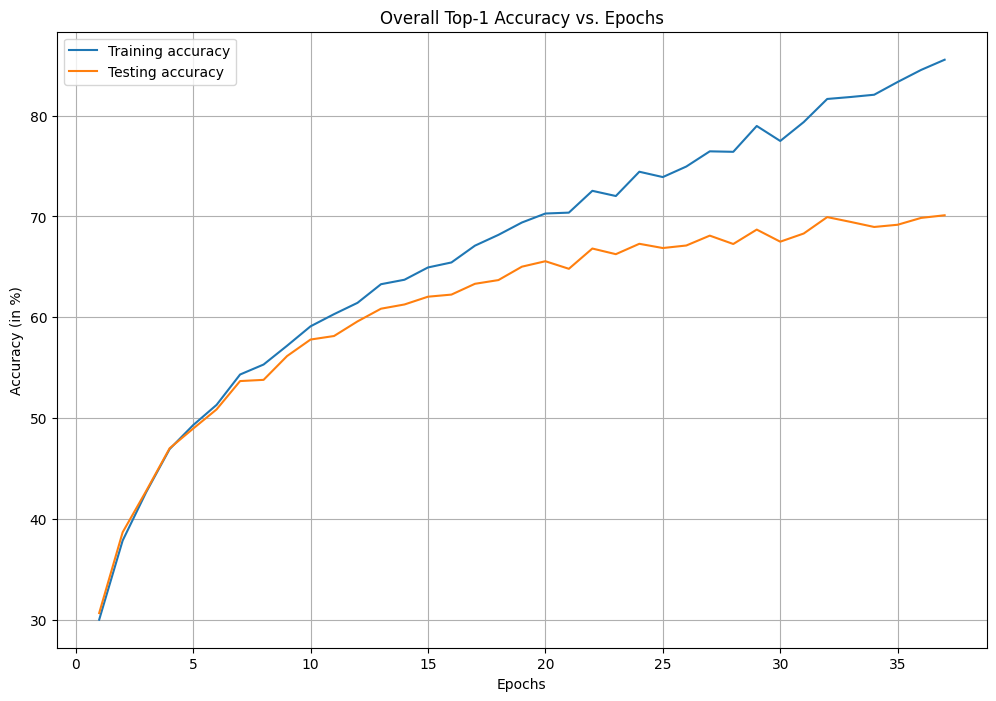

In [31]:
#create values for x axis based number of epochs, the model is trained (early stopping)
num_of_x = len(train_accuracy_list)
epochs_list = [i+1 for i in range(num_of_x)]

plt.figure(figsize=(12, 8))
plt.plot(epochs_list, train_accuracy_list, label='Training accuracy')
plt.plot(epochs_list, test_accuracy_list, label='Testing accuracy')
plt.title('Overall Top-1 Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### **8. Visualize the model training process through graphs of loss for training and testing dataset**

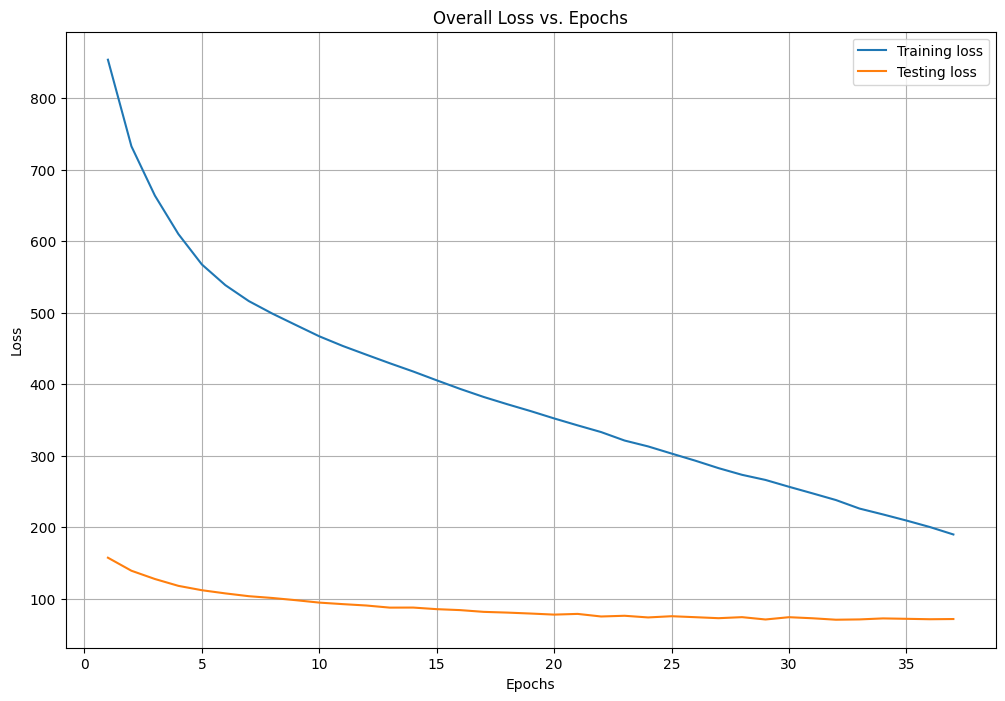

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_list, train_loss_list, label='Training loss')
plt.plot(epochs_list, test_loss_list, label='Testing loss')
plt.title('Overall Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### **8. Visualize the model training process through graphs of Top-5 accuracy for training and testing dataset**

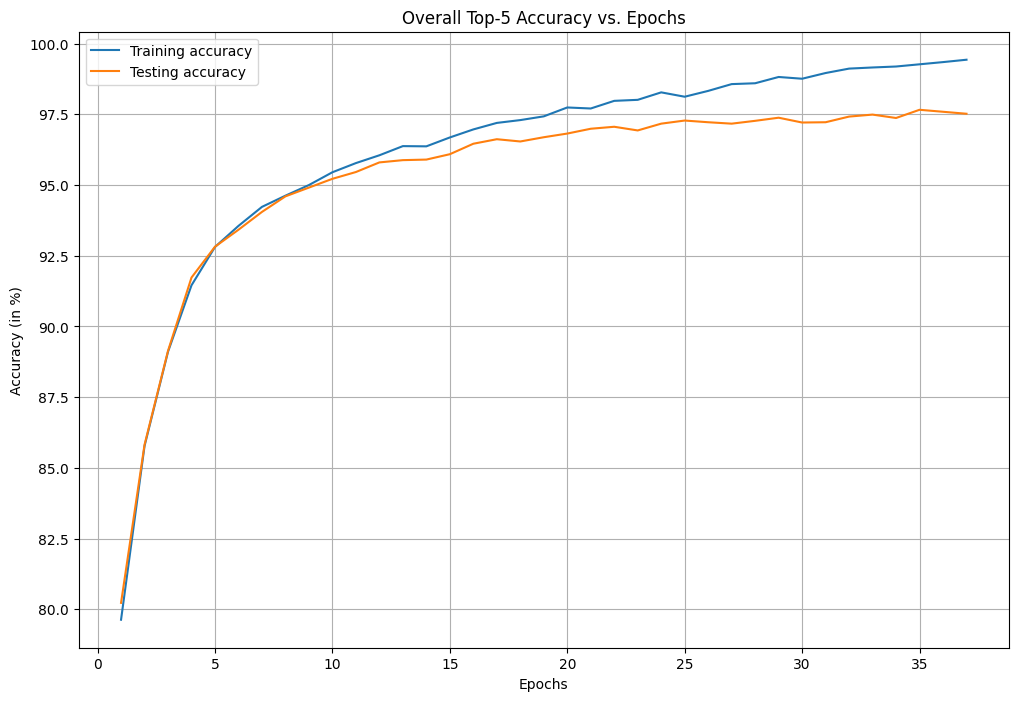

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_list, train_top_k_accuracy_list, label='Training accuracy')
plt.plot(epochs_list, test_top_k_accuracy_list, label='Testing accuracy')
plt.title("Overall Top-{} Accuracy vs. Epochs".format(top_k_value))
plt.xlabel('Epochs')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### **9. Visualize the model training process through graphs of Top-1 accuarcy for each class in training dataset**

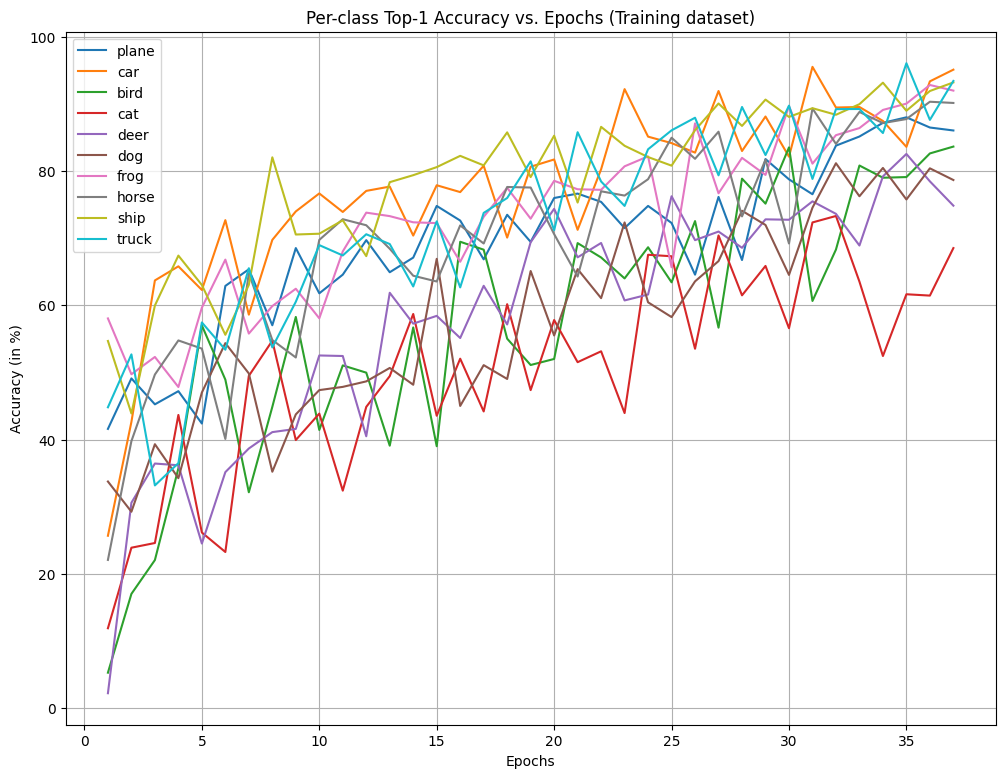

In [38]:
plt.figure(figsize=(12, 9))
for i in range(10):
    plt.plot(epochs_list, [epoch[i] for epoch in train_per_class_accuracy_list], label=classes[i])
plt.title('Per-class Top-1 Accuracy vs. Epochs (Training dataset)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### **9. Visualize the model training process through graphs of Top-1 accuarcy for each class in testing dataset**

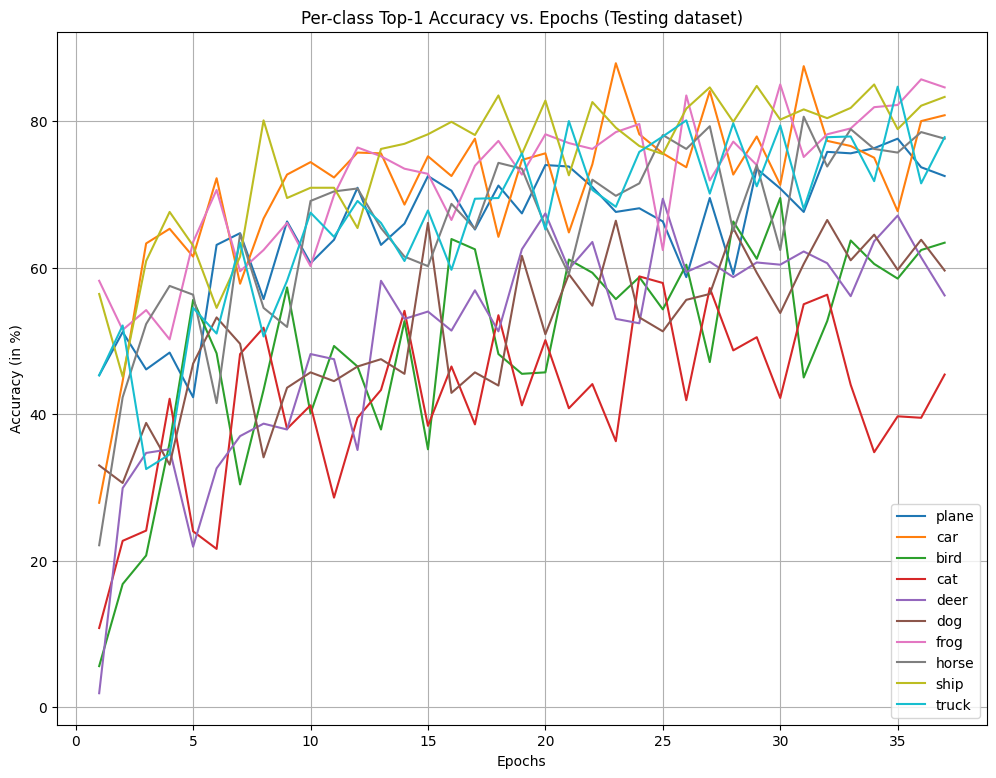

In [39]:
plt.figure(figsize=(12, 9))
for i in range(10):
    plt.plot(epochs_list, [epoch[i] for epoch in test_per_class_accuracy_list], label=classes[i])
plt.title('Per-class Top-1 Accuracy vs. Epochs (Testing dataset)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### **10. Load the best trained model to predict output on general data**

In [40]:
#import the library to load the input image
from PIL import Image

# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Resize the image to 32x32 pixels (CIFAR10-dataset image size)
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

# Load the best pre-trained model
model = torch.load('/content/epoch_32_accuarcy_69.94.pth')
model.eval() # Set the model to evaluation mode

Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### **11. Load a sample input image to see the model prediction**

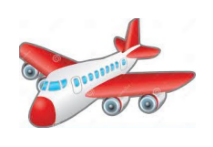

The input image belongs to the class: plane


In [41]:
# Path of the input image
image_path = 'sample_1.png'

# Load the input image and convert it to RGB image
image = Image.open(image_path)

plt.figure(figsize=(2.5,2.5))
# Display the image using Matplotlib
plt.imshow(image)
# Turn off axis labels
plt.axis('off')
plt.show()

# remove alpha channel if present in input image
if image.mode == 'RGBA':
    image = image.convert('RGB')
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Disable gradient computation since model is used for evaluation
with torch.no_grad():
    output = model(image) # Get the model prediction for the input image
    _, predicted_class = torch.max(output, 1) # Get index of the predicted class

# Print the predicted class
print(f"The input image belongs to the class: {classes[predicted_class.item()]}")

### **12. Load one more sample input image to see the model prediction**

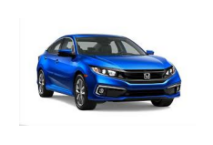

The input image belongs to the class: plane


In [42]:
# Path of the input image
image_path = '/content/sample_2.png'

# Load the input image and convert it to RGB image
image = Image.open(image_path)

plt.figure(figsize=(2.5,2.5))
# Display the image using Matplotlib
plt.imshow(image)
# Turn off axis labels
plt.axis('off')
plt.show()

# remove alpha channel if present in input image
if image.mode == 'RGBA':
    image = image.convert('RGB')
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Disable gradient computation since model is used for evaluation
with torch.no_grad():
    output = model(image) # Get the model prediction for the input image
    _, predicted_class = torch.max(output, 1) # Get index of the predicted class

# Print the predicted class
print(f"The input image belongs to the class: {classes[predicted_class.item()]}")